In [204]:
from sklearn.linear_model import Lasso
import numpy as np
import pandas as pd

In [229]:
url='https://raw.githubusercontent.com/cathyxinxyz/Capstone_Project_1/master/Datasets/Combined_data_new.csv'
df=pd.read_csv(url,index_col='FIPS',encoding="ISO-8859-1")

In [228]:
#read in variable information and build variable information dictionary with variable names as key
url='https://raw.githubusercontent.com/cathyxinxyz/Capstone_Project_1/master/Datasets/Food_atlas/Var_name_info.csv'
var_info_df=pd.read_csv(url,encoding="ISO-8859-1", index_col='var_name')

In [242]:
url='https://raw.githubusercontent.com/cathyxinxyz/Capstone_Project_1/master/Datasets/geography/Rural_urban_codes.csv'
RB_df=pd.read_csv(url,encoding="ISO-8859-1", index_col='RUCC_2013')

ParserError: Error tokenizing data. C error: Expected 2 fields in line 3, saw 3


In [230]:
from sklearn import preprocessing
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

df=df[df.columns.difference(['State','County'])]

In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3143 entries, 1001 to 56045
Data columns (total 58 columns):
Division                             3143 non-null object
Region                               3143 non-null object
prevalence of diabetes               3142 non-null float64
prevalence of obesity                3142 non-null float64
prevalence of physical inactivity    3142 non-null float64
var1                                 3096 non-null float64
var10                                3124 non-null float64
var11                                3124 non-null float64
var12                                3124 non-null float64
var13                                3124 non-null float64
var14                                3143 non-null float64
var15                                3143 non-null float64
var16                                3143 non-null float64
var17                                3143 non-null float64
var18                                3141 non-null float64
var19 

In [231]:
df['RUCC_2013']=df['RUCC_2013'].astype(str)

In [232]:
df_with_dummy = pd.get_dummies(df, drop_first=True)

In [233]:
df_with_dummy=df_with_dummy.drop('var57', axis=1)
df_with_dummy.shape

(3143, 74)

missing value imputation

In [234]:
#pipeline with missing values imputation and regression
# Import the Imputer module
from sklearn.preprocessing import Imputer
# Setup the Imputation transformer: imp
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp_data=imp.fit_transform(df_with_dummy.values)
imp_data.shape
imp_df=pd.DataFrame(imp_data, index=df_with_dummy.index, columns=df_with_dummy.columns)

In [235]:
normed_data=preprocessing.scale(imp_df)
normed_df=pd.DataFrame(normed_data, index=imp_df.index, columns=imp_df.columns)


In [236]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X=normed_df.drop(['prevalence of diabetes'], axis=1).values
y=normed_df['prevalence of diabetes'].values

In [237]:
#vary the random state to get best result
l1_space = np.linspace(0, 1, 20)
alpha_space=np.linspace(0.0, 5, 20)

param_grid = {'l1_ratio': l1_space, 'alpha':alpha_space}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

elastic_net = ElasticNet()

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=10)

# Fit it to the training data
gm_cv.fit(X_train,y_train)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test,y_test)
mse = mean_squared_error(y_test, y_pred)

print("Tuned parameters: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))


Tuned parameters: {'alpha': 0.0, 'l1_ratio': 0.0}
Tuned ElasticNet R squared: 0.8080775616131862
Tuned ElasticNet MSE: 0.19589725106616487


In [215]:
elastic_net = ElasticNet(alpha=0, l1_ratio=0)
elastic_net.fit(X_train,y_train)

ElasticNet(alpha=0, copy_X=True, fit_intercept=True, l1_ratio=0,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

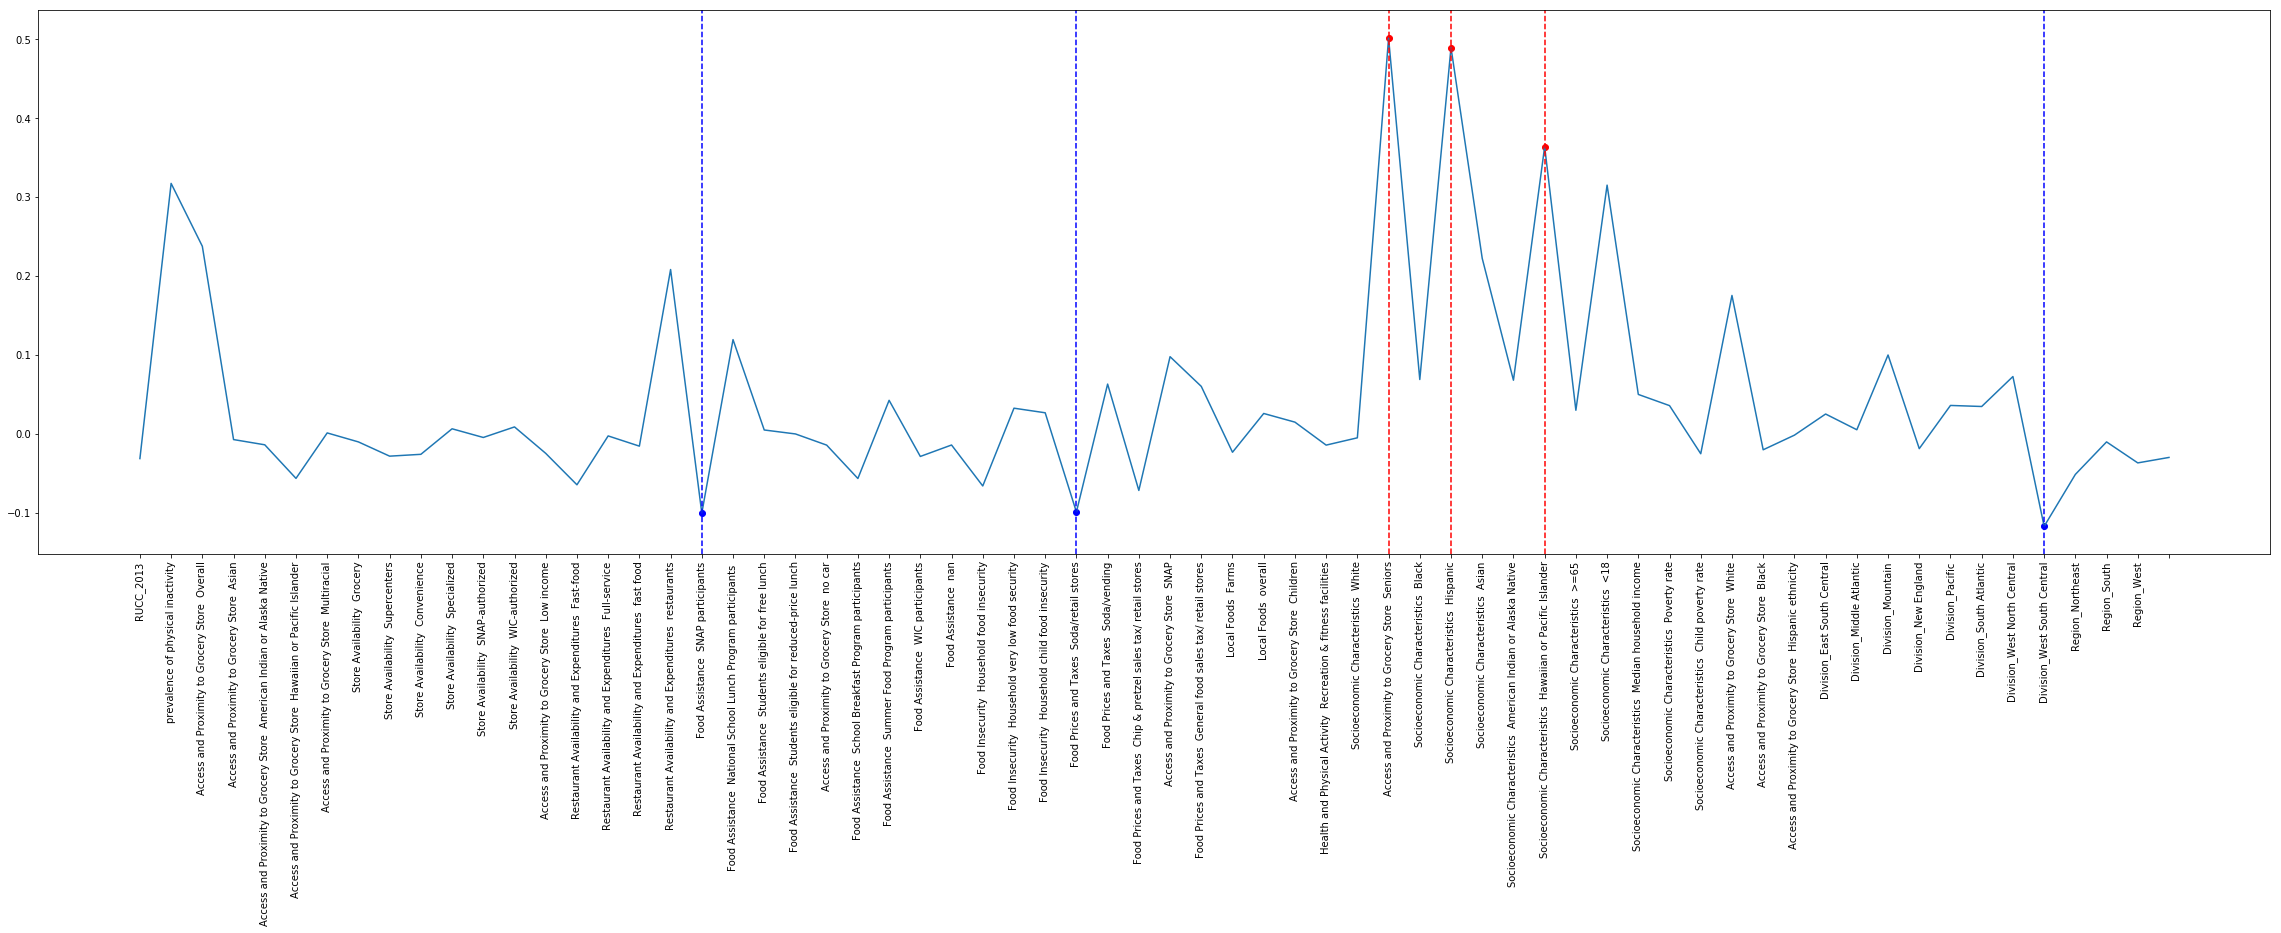

In [216]:
import matplotlib.pyplot as plt
features=[str(var_info_df.loc[c]['Category Name'])+'  '+str(var_info_df.loc[c]['Sub_subcategory Name']) if c in var_info_df.index else c
          for c in normed_df.drop(['prevalence of diabetes', 'prevalence of obesity'], axis=1).columns]
plt.figure(figsize=(40,10))
plt.plot(range(len(elastic_net.coef_)), elastic_net.coef_)
Top_three_impactful=sorted([(elastic_net.coef_[i], i) for i in range(len(elastic_net.coef_))], key=lambda tup:tup[0])[-3:]
Top_three_negative=sorted([(elastic_net.coef_[i], i) for i in range(len(elastic_net.coef_))], key=lambda tup:tup[0])[:3]
for i in range(3):
    plt.axvline(x=Top_three_impactful[i][1], linestyle='--', color='r')
    plt.scatter(Top_three_impactful[i][1], Top_three_impactful[i][0], color='r')
for i in range(3):
    plt.axvline(x=Top_three_negative[i][1], linestyle='--', color='b')
    plt.scatter(Top_three_negative[i][1], Top_three_negative[i][0], color='b')
plt.xticks(range(len(elastic_net.coef_)), features, rotation=90)

plt.show()

In [240]:
X_2=normed_df.drop(['prevalence of obesity'], axis=1).values
y_2=normed_df['prevalence of obesity'].values

In [241]:
#vary the random state to get best result
l1_space = np.linspace(0, 1, 20)
alpha_space=np.linspace(0.0, 5, 20)

param_grid = {'l1_ratio': l1_space, 'alpha':alpha_space}


X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=12345)

elastic_net = ElasticNet()

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=10)

# Fit it to the training data
gm_cv.fit(X_train,y_train)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test,y_test)
mse = mean_squared_error(y_test, y_pred)

print("Tuned parameters: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

Tuned parameters: {'alpha': 0.26315789473684209, 'l1_ratio': 0.0}
Tuned ElasticNet R squared: 0.7254913470216591
Tuned ElasticNet MSE: 0.288483044057792
